In [1]:
# Import notwendiger Bibliotheken
import nussl
from common import data, viz
from IPython.display import Audio
import IPython
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import librosa
import os
from scipy import signal
import matplotlib.pyplot as plt

c:\Users\Lukas\AppData\Local\Programs\Python\Python38\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
# STFT Parameter setzen
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
#stft_params = nussl.STFTParams(window_length=1024, hop_length=256, window_type='sqrt_hann')

# Pfad zu den Trainingsdaten festlegen
fg_path = "C:\\Users\\Lukas\\.nussl\\2025-tutorial\\foreground"

data_num = 40000
coherents = 0.5
source = 'vocals'

# Trainingsdaten mit `nussl` laden
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=data_num, coherent_prob=coherents)

In [3]:
# Funktionen zum Visualizieren der Waveform und Spectrogram

def show_wav(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_waveform(sources)
    plt.show()

def show_1wav(data):
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_waveform(data)
    plt.show()

def show_fre(sources):
    if isinstance(sources, list):
        sources = {f'Source {i}': s for i, s in enumerate(sources)}
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_sources_as_masks(sources, db_cutoff=-80)
    plt.tight_layout()
    plt.show()

def show_1fre(data):
    plt.figure(figsize=(10, 5))
    plt.plot()
    nussl.core.utils.visualize_spectrogram(data)
    plt.show()


In [4]:
item = train_data[5]
print(item.keys())
print(item['sources'].keys())
print(item['mix'].audio_data.shape)

dict_keys(['mix', 'sources', 'metadata'])
dict_keys(['vocals', 'drums', 'bass', 'other'])
(1, 220500)


dict_keys(['mix', 'sources', 'metadata'])


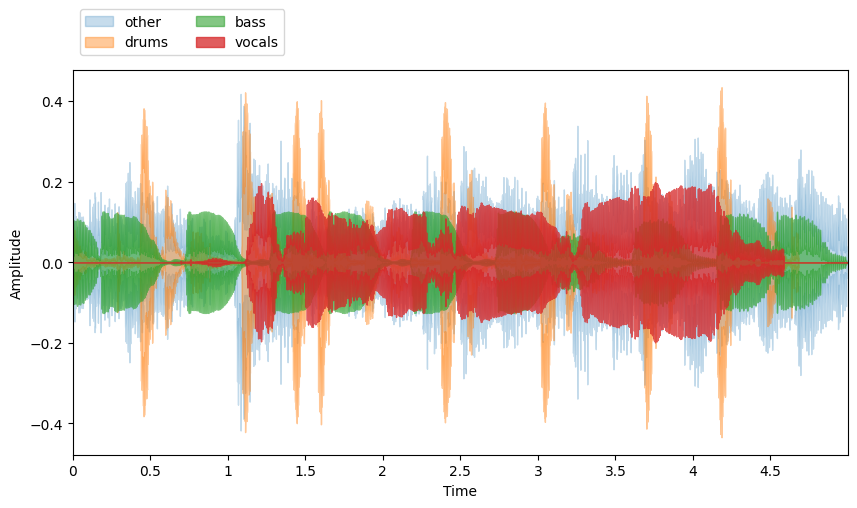

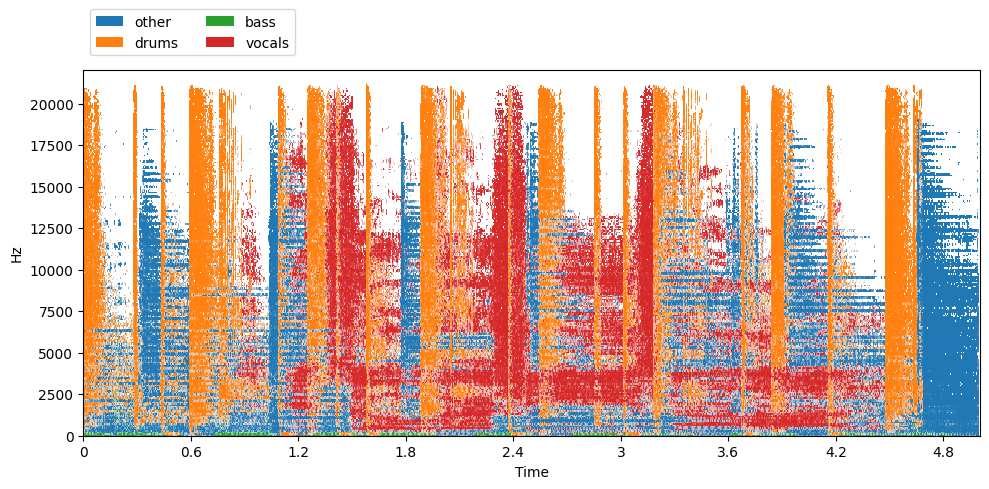

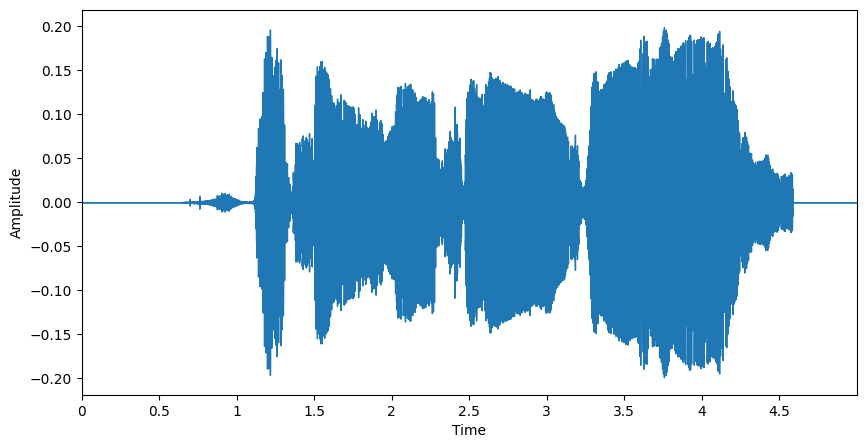

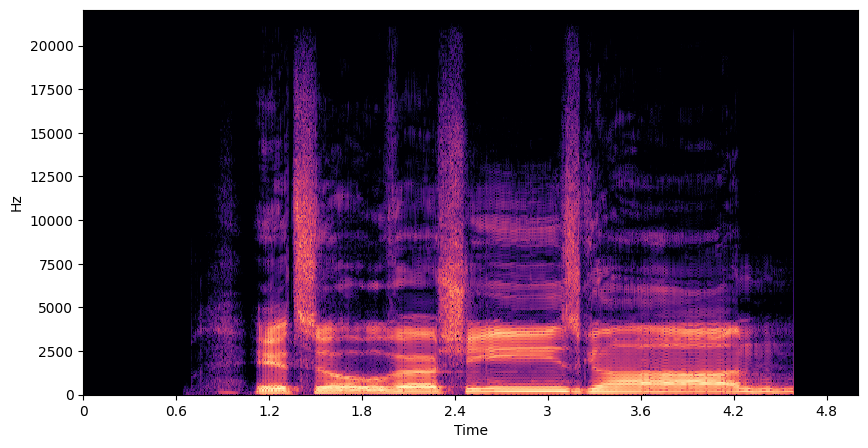

In [5]:
# Beispielhafte Audioausgabe zur Überprüfung
item = train_data[5]

print(item.keys())
display(Audio(data=item['mix'].audio_data, rate=item['mix'].sample_rate))
show_wav(item['sources'])
show_fre(item['sources'])
show_1wav(item['sources']['vocals'])
show_1fre(item['sources']['vocals'])

In [4]:
def preprocess(array, target_size=(512, 128)):
    n_fft = 512
    hop_length = 128
    win_length = 512

    original_max_amplitude = np.max(np.abs(array))
    stft = librosa.stft(array, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    stft_magnitude = np.abs(stft)
    phase = np.angle(stft)

    stft_magnitude = np.nan_to_num(stft_magnitude, nan=0.0, posinf=0.0, neginf=0.0)
    # Prüfen, ob das Array leer oder lautlos ist
    if np.max(stft_magnitude) == 0:  # Kein hörbares Signal
        mag_norm = np.zeros_like(stft_magnitude)
    else:
        mag_norm = stft_magnitude / np.max(stft_magnitude)
    
    # Sicherstellen, dass magnitude ein Tensor ist
    magnitude = tf.convert_to_tensor(mag_norm)
    
    # Füge eine Kanaldimension hinzu, falls nicht vorhanden
    if len(magnitude.shape) == 2:  # Nur Height und Width vorhanden
        magnitude = tf.expand_dims(magnitude, axis=-1)  # -> (Height, Width, 1)
    
    # Resize das Spektrogramm
    magnitude_resized = tf.image.resize(magnitude, target_size)
    return magnitude_resized, phase, original_max_amplitude

def postprocess(after, original_max_amplitude, phase):
    n_fft = 512
    hop_length = 128
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    after_resized = after_resized * original_max_amplitude

    complex_spectrogram = after_resized * np.exp(1j * phase)
    print(complex_spectrogram.shape)
    audio_reconstructed = librosa.istft(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return audio_reconstructed

In [46]:
def postprocess2(after, original_max_amplitude, phase):
    n_fft = 512
    hop_length = 39
    win_length = 512
    after_resized = tf.image.resize(after, (257, 1723))

    after_resized = np.squeeze(after_resized, axis=-1)

    #after_resized = after_resized.numpy()

    after_resized = after_resized * original_max_amplitude

    complex_spectrogram = after_resized * np.exp(1j * phase)
    print(complex_spectrogram.shape)
    audio_reconstructed = librosa.istft(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    #audio_reconstructed = librosa.griffinlim(complex_spectrogram, hop_length=hop_length, win_length=win_length)
    return audio_reconstructed

In [47]:
item = train_data[5]

test, ph, max = preprocess(item['mix'].audio_data[0])
print(test.shape)
wave = postprocess2(test, max, ph)
print(wave.shape)

(512, 128, 1)
(257, 1723)
(67158,)


In [5]:
for k in range(100):
    item = train_data[k]
    sum = 0
    for j in range(len(item['mix'].audio_data[0])): 
        #print(y, end='\r')
        sum = sum + abs(item['sources'][source].audio_data[0][j])
    print(k, ": ", sum, "\n")

0 :  6848.709534885453 

1 :  6468.580738429507 

2 :  13905.595422455506 

3 :  10432.050489677735 

4 :  1120.5283170313876 

5 :  5332.468364854768 

6 :  5940.126834581248 

7 :  4123.659269121371 

8 :  1772.244294191482 

9 :  4258.558949016236 

10 :  14699.863638133756 

11 :  648.041383834664 

12 :  526.1272396086764 

13 :  10345.29681100698 

14 :  6612.290402778461 

15 :  3680.8267078030062 

16 :  7039.188462802888 

17 :  3762.1743564741546 

18 :  10948.122786605356 

19 :  0.0 

20 :  1720.9700588512587 

21 :  5440.087410303207 

22 :  10468.225300001786 

23 :  6456.743042588912 

24 :  2073.1932550214615 

25 :  12128.90078158991 

26 :  6850.453102476413 

27 :  11604.654475805952 

28 :  8894.869297665397 

29 :  6898.07557087773 

30 :  4924.712461968794 

31 :  20054.72045613474 

32 :  10713.176503224926 

33 :  4467.90180079444 

34 :  4545.757711708051 

35 :  11218.189294367377 

36 :  10433.248441435917 

37 :  1421.887525655315 

38 :  3181.637612191356 


In [5]:
item = train_data[11]

display(Audio(data=item['mix'].audio_data, rate=item['mix'].sample_rate))
print(len(item['mix'].audio_data[0]))
#print(item['mix'].audio_data[0][5])

sum = 0
for j in range(len(item['mix'].audio_data[0])): 
    #print(y, end='\r')
    sum = sum + abs(item['sources'][source].audio_data[0][j])

print(sum)

220500
648.041383834664


In [6]:
good_frames = 0
threshold = 5000
x_songs = []
y_songs = []
for i in range(data_num):
    item = train_data[i]
    sum = 0
    for j in range(len(item['mix'].audio_data[0])): 
        #print(y, end='\r')
        sum = sum + abs(item['sources'][source].audio_data[0][j])

    if(sum > threshold):
        good_frames = good_frames + 1
        x_datapoint, ph, max = preprocess(item['mix'].audio_data[0])
        x_songs.append(x_datapoint)

        y_datapoint, ph, max = preprocess(item['sources'][source].audio_data[0])
        y_songs.append(y_datapoint)

    print(i+1, " / ", data_num, "| good frames: ", good_frames, end='\r')
    
print(good_frames)

25293  /  40000 | good frames:  25293


In [7]:
x_songs = []
y_songs = []
for i in range(data_num):
    item = train_data[i]
    x_datapoint, ph, max = preprocess(item['mix'].audio_data[0])
    x_songs.append(x_datapoint)

    y_datapoint, ph, max = preprocess(item['sources'][source].audio_data[0])
    y_songs.append(y_datapoint)

    print(i+1, " / ", data_num, end='\r')

KeyboardInterrupt: 

In [7]:
print(len(x_songs))
print(len(y_songs))
print(x_songs[good_frames-1].shape)

audi = postprocess(x_songs[good_frames-1], max, ph)

audio_vocal = nussl.AudioSignal()
audio_vocal.audio_data = audi

item = train_data[good_frames-1]

display(Audio(data=item['mix'].audio_data, rate=item['mix'].sample_rate))

display(Audio(data=audio_vocal.audio_data, rate=item['mix'].sample_rate))

audi = postprocess(y_songs[good_frames-1], max, ph)

audio_vocal2 = nussl.AudioSignal()
audio_vocal2.audio_data = audi

display(Audio(data=audio_vocal2.audio_data, rate=item['mix'].sample_rate))

25293
25293
(512, 128, 1)
(257, 1723)


(257, 1723)


In [8]:
x_songs = np.array(x_songs)
y_songs = np.array(y_songs)

print(x_songs.shape)
print(y_songs.shape)

(25293, 512, 128, 1)
(25293, 512, 128, 1)


In [9]:
import zipfile
# Speichere die Arrays in einer .zip-Datei
with zipfile.ZipFile(f'E:\\Projektarbeit\\Daten\\Training_{source}_{good_frames}_co={coherents}_th={threshold}.zip', 'w') as zipf:
    # Speichere jedes Array als separate .npy-Datei
    np.save('X_train.npy', x_songs)
    np.save('y_train.npy', y_songs)
    
    # Füge die .npy-Dateien zur .zip hinzu
    zipf.write('X_train.npy')
    zipf.write('y_train.npy')

os.remove('X_train.npy')
os.remove('y_train.npy')